In [1]:
import numpy as np
import matplotlib.pyplot as plt



import numpy as np
from numpy.lib.arraysetops import isin
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV


In [2]:
from scipy.integrate import solve_ivp
from ssmlearnpy.utils import ridge
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate
from ssmlearnpy.reduced_dynamics.normalform import NormalForm, NonlinearCoordinateTransform
from sklearn.preprocessing import PolynomialFeatures

from ssmlearnpy.reduced_dynamics.normalform import NonlinearCoordinateTransform, NormalForm, create_normalform_transform_objective, prepare_normalform_transform_optimization, unpack_optimized_coeffs
from scipy.optimize import minimize
import numpy as np
from scipy.io import savemat

In [3]:
from ssmlearnpy.reduced_dynamics.normalform import NormalForm, wrap_optimized_coefficients


I fit the reduced dynamics to infer the eigenvalues 

In [4]:
from scipy.integrate import solve_ivp
from ssmlearnpy.utils import ridge
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate


In [5]:

def vectorfield(t,x):
    # needed to test regression
    # damped duffing oscillator with fixed points at x=0 and x=+/-1.
    # x[0] is position, x[1] is velocity
    return np.array([x[1], x[0]-x[0]**3 - 0.1*x[1]])


In [35]:
 t = np.linspace(0, 100, 1000)
dt = t[1] - t[0]
ic_0 = np.array([0.1, 0])
ic_1 = np.array([0.112, 0])
sol_0 = solve_ivp(vectorfield, [t[0], t[-1]], ic_0, t_eval=t)
sol_1 = solve_ivp(vectorfield, [t[0], t[-1]], ic_1, t_eval=t)
trajectories = [sol_0.y - np.array([1,0]).reshape(-1,1), sol_1.y - np.array([1,0]).reshape(-1,1)]
times = [t, t]
X, y  = shift_or_differentiate(trajectories, times, 'flow') # get an estimate for the linear part
#print(X[0].shape)
# add the constraints to the fixed points explicitly
constLHS = [[-1, 0]]
constRHS = [[0, 0]]
cons = [constLHS, constRHS]
# Fit reduced model
mdl = ridge.get_fit_ridge(X, y, poly_degree = 5, constraints = cons)
linearPart = mdl.map_info['coefficients'][:,:2]
w, v = np.linalg.eig(linearPart)
#print(np.linalg.inv(v)@linearPart@v)
linpartDiag = np.linalg.inv(v)@linearPart@v
# v^{-1}@A@v is diagonal. transform the coordinates with v^{-1}.
newcoord = [np.linalg.inv(v)@x for x in trajectories]

INFO   2023-03-30 23:39:53 ridge Transforming data
INFO   2023-03-30 23:39:53 ridge Skipping CV on ridge regression
INFO   2023-03-30 23:39:53 ridge Fitting regression model


In [36]:
NF, n_unknowns_dynamics, n_unknowns_transformation, objectiv = create_normalform_transform_objective(times, newcoord, linpartDiag, degree = 3)


In [37]:
    icfrommatlab = np.array([
  -0.046665229741644,
   0.088871461583745,
  -0.026512243121989,
  -0.081083271970684,
   0.323878856507470,
  -0.039156803945355,
  -0.097782606679839,
  -0.671912310868208,
  -1.346404263906166,
   0.222731265038940,
   0.014122867866736,
  -0.003328268772583,
  -0.009526614976568,
   0.902348990674412])
    ic_ = np.array([1, 0,1, 1,1, 0, 0, 1, 0, 0, 0, 1, 0, 0])
    res = minimize(objectiv, icfrommatlab, method='BFGS', options={'disp': True, 'maxiter':5000})
    d = unpack_optimized_coeffs(res.x, 1, NF, n_unknowns_dynamics, n_unknowns_transformation)
#    print(d['coeff_dynamics'])

Optimization terminated successfully.
         Current function value: 0.709177
         Iterations: 39
         Function evaluations: 735
         Gradient evaluations: 49


In [38]:
d['coeff_transformation'].shape

(1, 7)

In [39]:
coef, trf = wrap_optimized_coefficients(1, [0,0], 3, d )

In [40]:
ndofs =1


In [41]:
coef[0,:]

array([ 1.        +0.j        ,  0.        +0.j        ,
        0.01461794+0.52656807j,  0.0039621 +1.0196608j ,
        0.01770001-0.15200134j, -0.59094328-0.01337581j,
        0.        +0.j        , -0.04166034+0.0876045j ,
        0.09627425-0.02268084j])

In [42]:
coef[1,:]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [43]:
d['coeff_transformation']

array([[ 0.01461794+0.52656807j,  0.0039621 +1.0196608j ,
         0.01770001-0.15200134j, -0.59094328-0.01337581j,
         0.        +0.j        , -0.04166034+0.0876045j ,
         0.09627425-0.02268084j]])

In [44]:
aa = trf.inverse_transform(newcoord[0])

In [45]:
aa


array([[-6.30856094e-02-7.32488643e-01j],
       [-4.52105654e-02-7.30791767e-01j],
       [-2.72170365e-02-7.27757709e-01j],
       [-8.99273429e-03-7.23379453e-01j],
       [ 9.56806756e-03-7.17635285e-01j],
       [ 2.85689657e-02-7.10491219e-01j],
       [ 4.81086652e-02-7.01901288e-01j],
       [ 6.82779787e-02-6.91807888e-01j],
       [ 8.91557201e-02-6.80142558e-01j],
       [ 1.10797628e-01-6.66827891e-01j],
       [ 1.33257384e-01-6.51764369e-01j],
       [ 1.56564931e-01-6.34840602e-01j],
       [ 1.80715715e-01-6.15937937e-01j],
       [ 2.05666392e-01-5.94932213e-01j],
       [ 2.31330536e-01-5.71695728e-01j],
       [ 2.57574487e-01-5.46099457e-01j],
       [ 2.84213497e-01-5.18015465e-01j],
       [ 3.11008428e-01-4.87319477e-01j],
       [ 3.37486047e-01-4.54017697e-01j],
       [ 3.62971017e-01-4.18264408e-01j],
       [ 3.87451602e-01-3.79708422e-01j],
       [ 4.10629635e-01-3.38118476e-01j],
       [ 4.31913808e-01-2.93451579e-01j],
       [ 4.50499588e-01-2.45871265

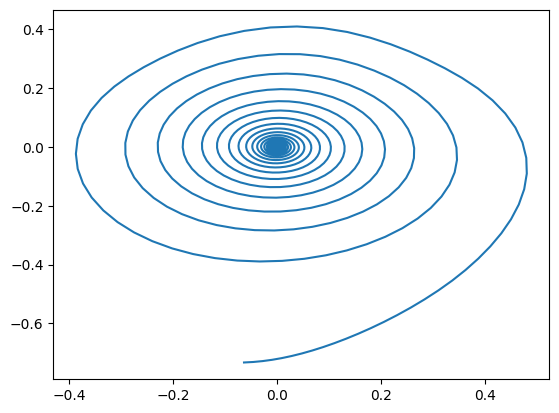

In [46]:
plt.plot(np.real(aa[:,0]), np.imag(aa[:,0]))

In [47]:
from scipy.integrate import solve_ivp

In [48]:
d['coeff_transformation'].shape

(1, 7)

In [49]:
def vectorfieldNf(t,x):
    return NF.LinearPart[0,0]*x + d['coeff_dynamics'][NF.dynamics_structure.reshape(1,-1)]*x**2*np.conj(x)


In [50]:
icc = aa[0,0]

In [51]:
icc

(-0.06308560935404711-0.7324886429746639j)

In [52]:
vectorfieldNf(0, icc).shape

(1,)

In [54]:
sol = solve_ivp(vectorfieldNf, [0, 100], [icc], t_eval=t)

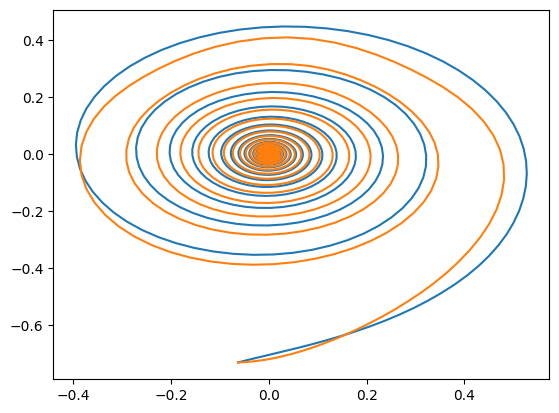

In [55]:
plt.plot(np.real(sol.y[0,:]), np.imag(sol.y[0,:]))
plt.plot(np.real(aa[:,0]), np.imag(aa[:,0]))

In [56]:
np.max(np.conj(aa[:,0])-aa[:,1])

IndexError: index 1 is out of bounds for axis 1 with size 1

In [57]:
NF.LinearPart[0,0]


(-0.0487346658291207+1.4125256444622925j)

In [58]:
np.dtype(newcoord[0][0,0])

dtype('complex128')

In [59]:
newcoord[0][0,0]

-0.7792997761935636j

In [60]:
d['coeff_dynamics']

array([[ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
        -0.19143598-2.12228164j,  0.        +0.j        ,
         0.        +0.j        ]])

solution from matlab:

In [ ]:
best = np.array([   0.002818889746235,
   0.059415462775561,
   0.030497977640260,
  -1.461040586269820,
  -0.203159058632970,
   0.244890089585910,
  -0.526966670910339,
   0.848666205722672,
   1.670285068564227,
  -0.242585661224423,
  -0.096320040469781,
   0.278734356071433,
  -0.068636242977714,
  -5.114603675927176,
])

In [19]:
[::-1]

21989.50094299669

In [39]:
gamma_from_fastSSM=-0.027779192851483 - 1.3899746434502681j

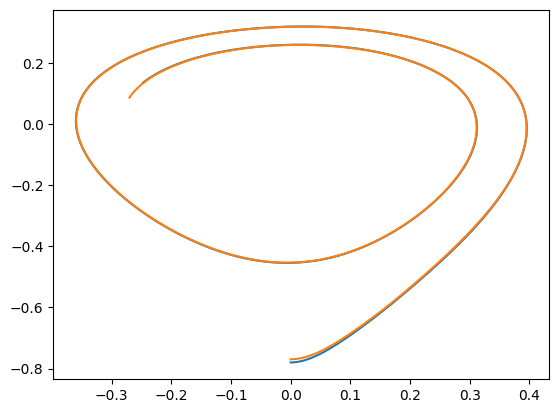

In [38]:
plt.plot(np.real(newcoord[0][0,:]), np.imag(newcoord[0][0,:]))
#plt.plot(np.real(newcoord[0][1,:]), -np.imag(newcoord[0][1,:])) # conjugate
plt.plot(np.real(newcoord[1][1,:]), -np.imag(newcoord[1][1,:]))